In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import seaborn as sns
import requests
import matplotlib.pyplot as plt

from torch import nn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from pathlib import Path

In [3]:
# Hyperparameters
N_SAMPLES=1000
N_FEATURES=2
NUM_CLASSES=4
LEARNING_RATE=0.01

In [4]:
X, y = make_blobs(n_samples=N_SAMPLES, n_features=N_FEATURES, centers=NUM_CLASSES)
X[:5], y[:5]

(array([[ 5.84557779, -7.12320144],
        [-8.53557328,  0.88309115],
        [ 5.67647658, -6.64952317],
        [ 9.14802312, -5.23944717],
        [ 5.62150088, -6.73814162]]),
 array([2, 1, 2, 3, 2]))

In [5]:
blobs = pd.DataFrame({
    'X1': X[:, 0],
    'X2': X[:, 1],
    'label': y
})

blobs.head(10)

,X1,X2,label
0,5.845578,-7.123201,2
1,-8.535573,0.883091,1
2,5.676477,-6.649523,2
3,9.148023,-5.239447,3
4,5.621501,-6.738142,2
5,-9.258932,3.145696,1
6,4.473912,1.187546,0
7,3.471814,2.910670,0
8,4.116218,1.451104,0
9,10.131523,-8.183106,3


In [6]:
blobs.label.value_counts()

label
2    250
1    250
3    250
0    250
Name: count, dtype: int64

In [7]:
len(blobs.label)

1000

In [8]:
X_sample = X[0]
y_sample = y[0]
print(f'For input {X_sample} the output is {y_sample}')

For input [ 5.84557779 -7.12320144] the output is 2


In [9]:
X.shape, y.shape

((1000, 2), (1000,))

<Axes: xlabel='X1', ylabel='X2'>

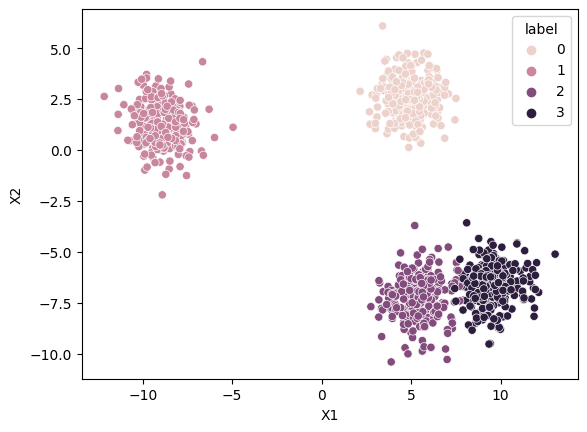

In [10]:
sns.scatterplot(data=blobs, x='X1', y='X2', hue='label')

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
X_train, X_test = torch.from_numpy(X_train).type(torch.float), torch.from_numpy(X_test).type(torch.float)
y_train, y_test = torch.from_numpy(y_train).type(torch.LongTensor), torch.from_numpy(y_test).type(torch.LongTensor)

In [12]:
def acc(true, pred):
    correct = torch.eq(true, pred).sum().item()
    acc = (correct / len(true)) * 100
    return acc

In [13]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)


model = BlobModel(input_features=N_FEATURES, output_features=NUM_CLASSES)
model

BlobModel(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=LEARNING_RATE)

In [15]:
model(X_train)[:5]

tensor([[ 0.0950, -0.0841,  0.7899,  0.9544],
        [ 0.1452, -0.1925,  0.6231,  0.8436],
        [ 0.2073, -0.1977,  0.7338,  0.9814],
        [-0.5989, -0.1469,  0.0508, -0.2411],
        [ 0.1540,  0.5425, -0.6295, -1.0340]], grad_fn=<SliceBackward0>)

In [16]:
y_logits = model(X_test)
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.1504, -0.1669,  0.6643,  0.8906],
        [-0.6867, -0.0802,  0.1432, -0.2853],
        [ 0.0727, -0.0028,  0.9660,  1.0830],
        [ 0.2952, -0.0519,  1.0783,  1.3849],
        [ 0.1972,  0.6134, -0.6355, -1.0788]], grad_fn=<SliceBackward0>)
tensor([[0.1819, 0.1325, 0.3042, 0.3814],
        [0.1510, 0.2770, 0.3463, 0.2256],
        [0.1405, 0.1303, 0.3433, 0.3859],
        [0.1456, 0.1029, 0.3186, 0.4329],
        [0.3096, 0.4694, 0.1346, 0.0864]], grad_fn=<SliceBackward0>)


In [17]:
y_pred_probs[0].sum().item()

1.0

In [18]:
y_pred_probs[3]

tensor([0.1456, 0.1029, 0.3186, 0.4329], grad_fn=<SelectBackward0>)

In [19]:
y_pred_probs[3].argmax()

tensor(3)

In [20]:
epochs = 10000
for epoch in range(epochs):
    # Put the model in training mode
    model.train()
    # Forward pass
    train_logits = model(X_train)
    train_preds = torch.softmax(train_logits, dim=1).argmax(dim=1)
    # Calculate the loss and the accuracy
    train_loss = criterion(train_logits, y_train)
    train_acc = acc(y_train, train_preds)
    # Optimizer zero grad
    optimizer.zero_grad()
    # Backpropagation
    train_loss.backward()
    # Optimizer step
    optimizer.step()
    # Put the model in evaluation mode
    model.eval()
    # Turn off gradient tracking
    with torch.inference_mode():
        # Forward pass
        test_logits = model(X_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
        # Calculate the loss and the accuracy
        test_loss = criterion(test_logits, y_test)
        test_acc = acc(y_test, test_preds)
        # Print the progress every 1000 epochs
        if epoch % 1000 == 0:
            print(f'Epoch #{epoch} | Train Loss: {train_loss:.2f} Train Accuracy: {train_acc:.2f}% | Test Loss: {test_loss:.2f} Test Accuracy: {test_acc:.2f}%')

Epoch #0 | Train Loss: 1.20 Train Accuracy: 48.50% | Test Loss: 1.18 Test Accuracy: 48.00%
Epoch #1000 | Train Loss: 0.07 Train Accuracy: 97.62% | Test Loss: 0.09 Test Accuracy: 96.00%
Epoch #2000 | Train Loss: 0.06 Train Accuracy: 97.75% | Test Loss: 0.08 Test Accuracy: 96.50%
Epoch #3000 | Train Loss: 0.06 Train Accuracy: 97.75% | Test Loss: 0.07 Test Accuracy: 96.50%
Epoch #4000 | Train Loss: 0.05 Train Accuracy: 98.00% | Test Loss: 0.07 Test Accuracy: 97.00%
Epoch #5000 | Train Loss: 0.05 Train Accuracy: 98.12% | Test Loss: 0.06 Test Accuracy: 97.00%
Epoch #6000 | Train Loss: 0.05 Train Accuracy: 98.12% | Test Loss: 0.06 Test Accuracy: 97.50%
Epoch #7000 | Train Loss: 0.04 Train Accuracy: 98.38% | Test Loss: 0.05 Test Accuracy: 97.50%
Epoch #8000 | Train Loss: 0.04 Train Accuracy: 98.50% | Test Loss: 0.05 Test Accuracy: 98.50%
Epoch #9000 | Train Loss: 0.04 Train Accuracy: 98.62% | Test Loss: 0.04 Test Accuracy: 98.50%


In [21]:
if Path('helper_functions.py').is_file():
    print('helper_functions.py already exists. Skipping download...')
else:
    request = requests.get('https://raw.githubusercontent.com/TheCloudOracle/pytorch-deep-learning/refs/heads/main/helper_functions.py')
    with open('helper_functions.py', 'wb') as f:
        f.write(request.content)

from helper_functions import plot_decision_boundary

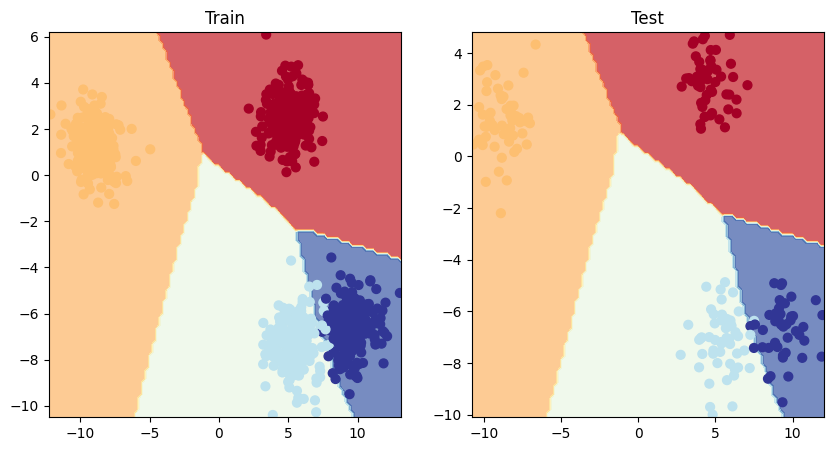

In [22]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model, X_test, y_test)